# Basic Q-Network with Keras ([blog post](https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/))

In [33]:
# OpenGym CartPole-v0
# -------------------
# demonstrates use of a basic Q-network (no target network)
# to solve OpenGym CartPole-v0 problem.
# orig author: Jaromir Janisch, 2016
# modified by: Kyle Dunovan, 2017
# to enable GPU
# import os    
# os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32"  

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random, math, gym
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

# some constants
ALPHA = .00035
LAMBDA = .001
GAMMA = 0.99
nHidden = 64
BATCH_SIZE = nHidden

$N_{states} = 4 $:
* $x$ - Position
* $\dot{x}$ - Velocity
* $\theta$ - Pole Angle
* $\dot{\theta}$ - Ang. Velocity


$\\\$


$N_{Actions} = 2$:
* `LEFT` 
* `RIGHT`

<img src="https://cdn-images-1.medium.com/max/1000/1*R5nOogFJJrhQj1cBBMrEIw.png" width=40% align=left>

**Brain**
---

The **`Brain`** class encapsulates the neural network. Our problem is simple enough so we will use only one hidden layer of 64 neurons, with ReLU activation function. The final layer will consist of only two neurons, one for each available action. Their activation function will be linear. Remember that we are trying to approximate the Q function, which in essence can be of any real value. Therefore we can’t restrict the output from the network and the linear activation works well.

Instead of simple gradient descent, we will use a more sophisticated algorithm RMSprop, and Mean Squared Error (mse) loss function.

In [34]:
#-------------------- BRAIN --------------------#
class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.model = self._createModel()
        # self.model.load_weights("cartpole-basic.h5")

    def _createModel(self):
        model = Sequential()
        model.add(Dense(activation='relu', input_dim=stateCnt, units=nHidden))
        model.add(Dense(activation='linear', units=actionCnt))
        opt = RMSprop(lr=ALPHA)
        model.compile(loss='mse', optimizer=opt)
        return model

    def train(self, x, y, epoch=1, verbose=0):
        self.model.fit(x, y, batch_size=nHidden, epochs=epoch, verbose=verbose)

    def predict(self, s):
        return self.model.predict(s)

    def predictOne(self, s):
        return self.predict(s.reshape(1, self.stateCnt)).flatten()

**Memory**
---

The purpose of the **`Memory`** class is to store experience (i.e., different states, actions and rewards). Somewhat superfluous for the current problem, but we will implement it anyway. It is a good abstraction for the experience replay part and will allow us to easily upgrade it to more sophisticated algorithms later on.

The add(sample) method stores the experience into the internal array, making sure that it does not exceed its capacity. The other method sample(n) returns n random samples from the memory.

In [35]:
class Memory:
    """ stored as ( s, a, r, s_ ) --> state(t), action(t), reward(t), state(t+1)
    see Agent.observe() method 
    """
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

**Agent**
---

Finally, the **`Agent`** class acts as a container for the agent related properties and methods. In other words, it uses the **`Brain`** and **`Memory`** to replay the past actions to choose optimal set of actions that maximize the rewards. 

The act(s) method implements the ε-greedy policy. With probability epsilon, it chooses a random action, otherwise it selects the best action the current ANN returns. We decrease the epsilon parameter with time, according to a formula:

$$\varepsilon = \varepsilon_{min} + (\varepsilon_{max} - \varepsilon_{min}) e^{-\lambda t}$$

The λ parameter controls the speed of decay. This way we start with a policy that explores greatly and behaves more and more greedily over time.

The observe(sample) method simply adds a sample to the agent’s memory.
```python
def observe(self, sample):  # in (s, a, r, s_) format
    self.memory.add(sample)   
```
The last replay() method is the most complicated part. Let’s recall, how the update formula looks like:

$$Q(s, a) \xrightarrow{} r + \gamma max_a Q(s', a)$$

This formula means that for a sample (s, r, a, s’) we will update the network’s weights so that its output is closer to the target. But when we recall our network architecture, we see, that it has multiple outputs, one for each action. We therefore have to supply a target for each of the outputs. But we want to adjust the ouptut of the network for only the one action which is part of the sample. For the other actions, we want the output to stay the same. So, the solution is simply to pass the current values as targets, which we can get by a single forward propagation.

Also, we have a special case of the episode terminal state. Remember that we set a state to None in the Environment class when the episode ended. Because of that, we can now identify such a state and act accordingly. When the episode ends, there are no more states after and so our update formula reduces to

$$ Q(s, a) \xrightarrow{} r $$ 

In this case, we will set our target only to r.

In [28]:
MEMORY_CAPACITY = 100000
MAX_EPSILON = 1
MIN_EPSILON = 0.01

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return np.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        
        # slowly decrease Epsilon based on our experience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)
        no_state = np.zeros(self.stateCnt)
        states = np.array([ o[0] for o in batch ])
        states_ = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = agent.brain.predict(states)
        p_ = agent.brain.predict(states_)

        x = np.zeros((batchLen, self.stateCnt))
        y = np.zeros((batchLen, self.actionCnt))        
        for i in range(batchLen):
            o = batch[i]
            s=o[0]; a=o[1]; r=o[2]; s_=o[3]
            t = p[i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * np.amax(p_[i])
            x[i] = s
            y[i] = t

        self.brain.train(x, y)

**Environment**
---

The **`Environment`** class is our wrapper for OpenAI Gym. Its only method **`run()`** handles one episode of the problem.

In [59]:
#-------------------- ENVIRONMENT --------------------#
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)
        
    def close(self):
        self.env.close()
        self.env.render(close=True)
        
    def run(self, agent, verbose=False):
        s = self.env.reset()
        R = 0 
        while True:            
            self.env.render()
            a = agent.act(s)
            s_, r, done, info = self.env.step(a)
            if done: s_ = None #terminal state
            agent.observe( (s, a, r, s_) )
            agent.replay()            
            s = s_
            R += r
            if done: break
        if verbose:
            print("Total reward: {}".format(R))
        return R
        

In [60]:
#-------------------- MAIN --------------------#
PROBLEM = 'CartPole-v0'
env = Environment(PROBLEM)
stateCnt  = env.env.observation_space.shape[0]
actionCnt = env.env.action_space.n
agent = Agent(stateCnt, actionCnt)

# some constants
ALPHA = .00035
LAMBDA = .001
GAMMA = 0.99
nHidden = 64
BATCH_SIZE = nHidden

rewards = []
maxEpisodes = 350
episode = 0
try:
    while True:
        reward_t = env.run(agent)
        rewards.append(reward_t)
        if episode >= maxEpisodes:
                break
        episode+=1
        if not episode%10:
            print(reward_t)
finally:
    agent.brain.model.save("cartpole-basic.h5")
    env.close()

[2017-09-19 15:39:03,727] Making new env: CartPole-v0


17.0
12.0
15.0
11.0
11.0
13.0
11.0
11.0
9.0
9.0
10.0
17.0
15.0
29.0
19.0
16.0
12.0
10.0
10.0
9.0
9.0
11.0
9.0
23.0
29.0
30.0
40.0
24.0
33.0
34.0
23.0
51.0
45.0
38.0
48.0


In [58]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(300):
    env.render()
    s_, r, done, info = env.step(env.action_space.sample()) # take a random action
    if done: break
# env.render(close=True)

[2017-09-19 15:22:42,115] Making new env: CartPole-v0


# N Hidden Units = 64

In [ ]:
ax1.plot(rewards, label=r'$\alpha$=.00035; $\lambda$=.001', linewidth=2)

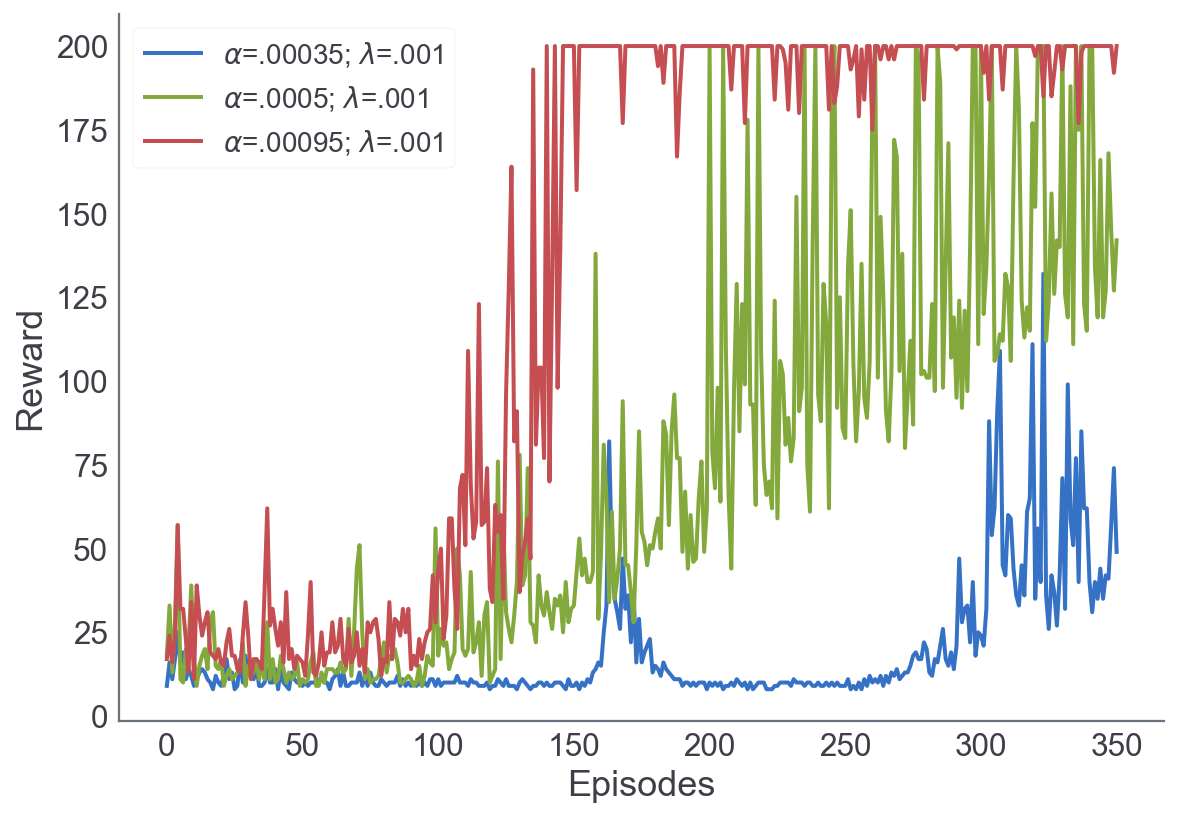

In [124]:
f, ax1 = plt.subplots(1, figsize=(8.5, 6))
ax1.plot(rewards, label=r'$\alpha$=.00035; $\lambda$=.001', linewidth=2)
ax1.plot(rewards2, label=r'$\alpha$=.0005; $\lambda$=.001', linewidth=2)
ax1.plot(rewards3, label=r'$\alpha$=.00095; $\lambda$=.001', linewidth=2)
sns.despine()
ax1.set_ylabel('Reward')
for ax in f.axes:
    ax.set_xlabel('Episodes')
    ax.legend(fontsize=14)
plt.tight_layout()

# N Hidden Units = 84

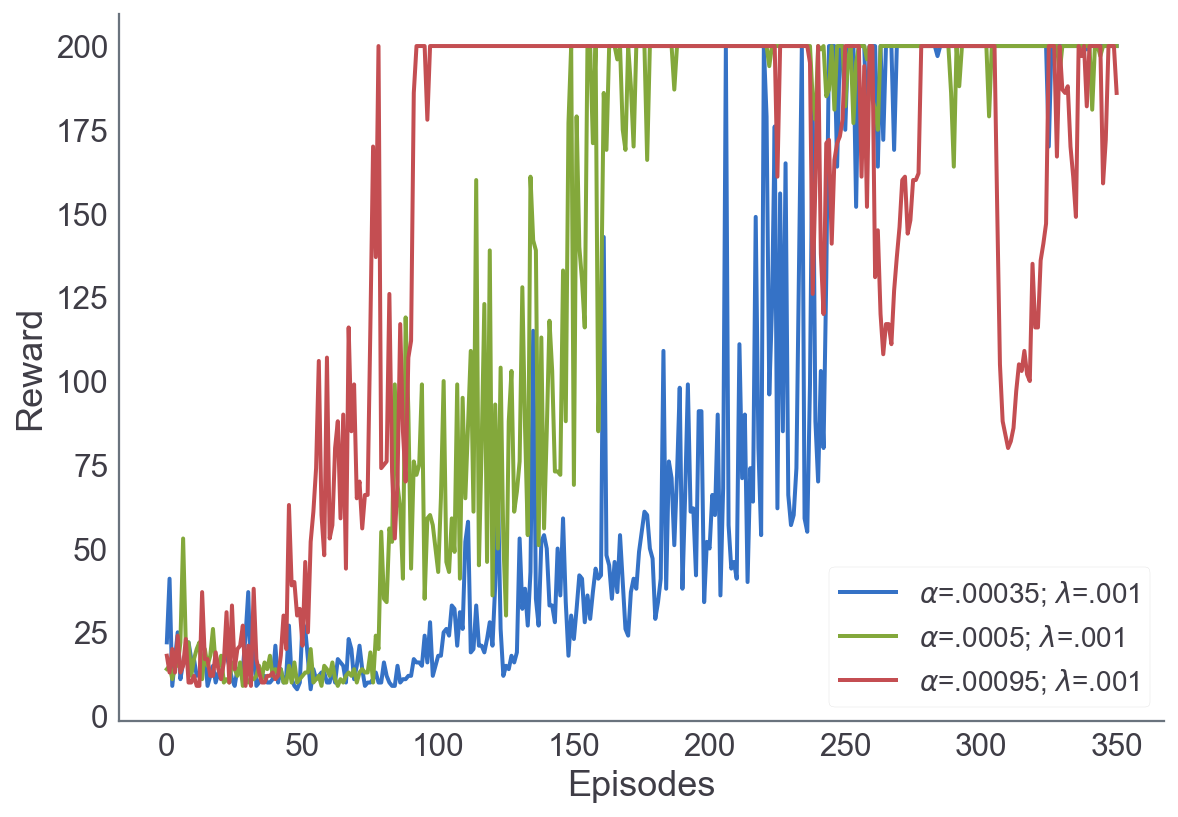

In [32]:
from jupyterthemes import jtplot
jtplot.style(context='paper', fscale=1.5, figsize=(14,9.5), grid=False)
f, ax1 = plt.subplots(1, figsize=(8.5, 6))
ax1.plot(rewards0, label=r'$\alpha$=.00035; $\lambda$=.001', linewidth=2)
ax1.plot(rewards, label=r'$\alpha$=.0005; $\lambda$=.001', linewidth=2)
ax1.plot(rewards2, label=r'$\alpha$=.00095; $\lambda$=.001', linewidth=2)
sns.despine()
ax1.set_ylabel('Reward')
for ax in f.axes:
    ax.set_xlabel('Episodes')
    ax.legend(fontsize=14)
plt.tight_layout()

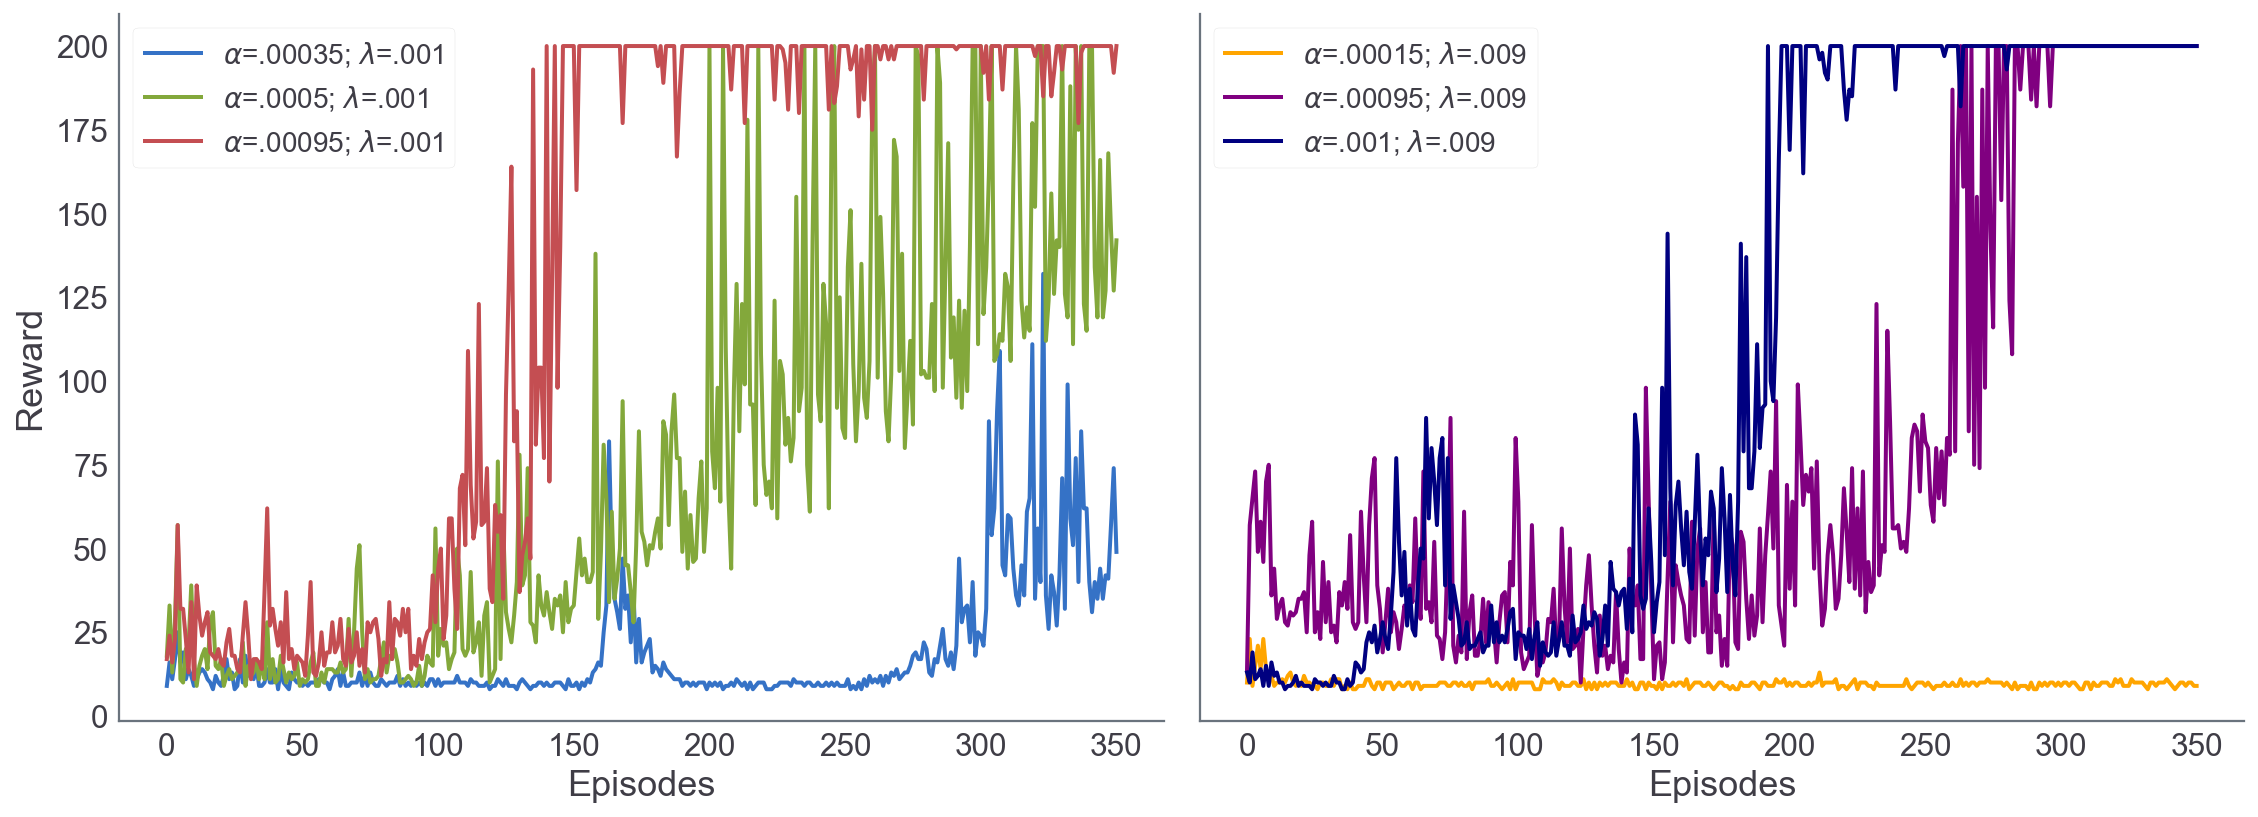

In [125]:
# from jupyterthemes import jtplot
# jtplot.style(context='paper', fscale=1.5, figsize=(14,9.5), grid=False)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax1.plot(rewards, label=r'$\alpha$=.00035; $\lambda$=.001', linewidth=2)
ax1.plot(rewards2, label=r'$\alpha$=.0005; $\lambda$=.001', linewidth=2)
ax1.plot(rewards3, label=r'$\alpha$=.00095; $\lambda$=.001', linewidth=2)

ax2.plot(rewards5, color='Orange', label=r'$\alpha$=.00015; $\lambda$=.009', linewidth=2)
ax2.plot(rewards4, color='Purple', label=r'$\alpha$=.00095; $\lambda$=.009', linewidth=2)
ax2.plot(rewards6, color='Navy', label=r'$\alpha$=.001; $\lambda$=.009', linewidth=2)

sns.despine()
ax1.set_ylabel('Reward')
for ax in f.axes:
    ax.set_xlabel('Episodes')
    ax.legend(fontsize=14)
plt.tight_layout()